# Pregled i popravak loše registriranih slika

Ova bilježnica korištena je za popravak loše obrezenih i registriranih MR snimaka. Određeni 2d aksijalni presjeci imali su odrezano previše moždanog tkiva, dok su neki sadržavali previše lubanje.

Za određene ispitanike isprobano je više parametara i napravljen kompromis odrezivanja rubnog tkiva i ostavljanja dijelova lubanje.

Na kraju skripte je konačan popis ispitanika i njihovih parametara.

Za ispitanike sa id-om 430, 433, 462 i 463 nisu uspješno pronađeni parametri koji bi davali odgovorajuće akcijalne presjeke pa se ti ispitanici neće korisitit u daljnjoj obradi.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
import pandas as pd
import os
import glob
import subprocess


## 1. Proces pronalaska ispravnih parametara 

Ovdje je proveden postupak ("igranje") pronalaska najboljih parametara za ekstrakciju mozga za ispitanike koji su vidno loše obrezani i registrirani na mni inicilanim parametrima iz "process_mni.sh" skripe (0.6 za t1 i 0.3 za t2).

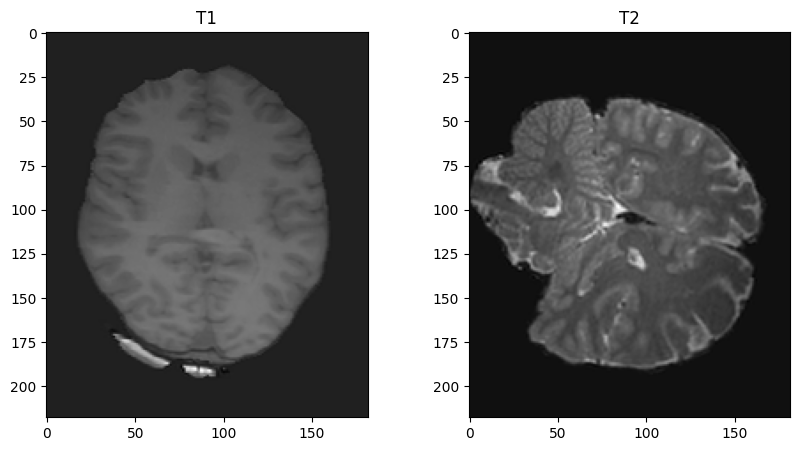

In [8]:
#ucitavanje slicea za 378 ispitanika
def load_slice(path_t1_slice, path_t2_slice):
    img_t1 = plt.imread(path_t1_slice)
    img_t2 = plt.imread(path_t2_slice)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_t1, cmap='gray')
    ax[0].set_title('T1')
    ax[1].imshow(img_t2, cmap='gray')
    ax[1].set_title('T2')
    plt.show()

load_slice('../data2/images/t1/IXI474_T1_slice.png', '../data2/images/t2/IXI474_T2_slice.png')

In [ ]:
#funkcija za obradu ispitanika (obrezivanje, registracija i aksijalno rezanje skena)
def process_subject(
    subject_id,
    T1_PATH,
    T2_PATH,
    bet_f_t1=0.7,
    bet_f_t2=0.4,
    output_tmp="../data_fix/tmp",
    output_t1_dir="../data_fix/images/t1",
    output_t2_dir="../data_fix/images/t2",
    remove_intermediate=True
):
    """
    Pokreće FSL pipeline za jedan subjekt:
      1) reorientacija T1 i T2
      2) BET (skull strip) s prilagodljivim 'f' parametrom
      3) linearna registracija T1 -> MNI
      4) linearna registracija T2 -> T1
      5) primjena T1->MNI transformacije na T2
      6) ekstrakcija aksijalnog slicea iz T1 i T2 u MNI prostoru
      7) brisanje međurezultata po želji

    subject_id        : npr. '378'
    T1_PATH           : putanja do originalne T1 slike
    T2_PATH           : putanja do originalne T2 slike
    bet_f_t1          : parametar -f za T1 BET (0.7 po defaultu)
    bet_f_t2          : parametar -f za T2 BET (0.4 po defaultu)
    output_prefix     : osnova za imenovanje output datoteka (npr. ../data_fix/tmp/IXI378)
    output_t1_dir     : gdje spremamo PNG slice za T1
    output_t2_dir     : gdje spremamo PNG slice za T2
    remove_intermediate: hoćemo li obrisati međufajlove nakon obrade (True/False)
    """

    # 1) Provjerimo i kreiramo direktorije za finalne sliceove ako ne postoje
    os.makedirs(output_tmp, exist_ok=True)
    subject_tmp_dir = os.path.join(output_tmp, f"IXI{subject_id}")
    os.makedirs(subject_tmp_dir, exist_ok=True)

    # 2) Složimo "output_prefix" da bude unutar subject_tmp_dir
    #    Svi međufajlovi (reorient, brain, mat...) čuvat će se tu.
    output_prefix = os.path.join(subject_tmp_dir, f"IXI{subject_id}")

    # 3) Kreiramo direktorije za finalne sliceove ako ne postoje
    os.makedirs(output_t1_dir, exist_ok=True)
    os.makedirs(output_t2_dir, exist_ok=True)
    
    # 2) Dohvatimo FSLDIR iz environmenta, složimo putanju do MNI mozga
    if "FSLDIR" not in os.environ:
        raise RuntimeError("FSL nije inicijaliziran (nedostaje varijabla okruženja FSLDIR).")
    FSLDIR = os.environ["FSLDIR"]
    MNI_BRAIN = os.path.join(FSLDIR, "data", "standard", "MNI152_T1_1mm_brain.nii.gz")
    
    # 3) Definiraj interne nazive datoteka
    t1_reorient     = f"{output_prefix}_T1_reorient.nii.gz"
    t2_reorient     = f"{output_prefix}_T2_reorient.nii.gz"
    t1_brain        = f"{output_prefix}_T1_brain.nii.gz"
    t2_brain        = f"{output_prefix}_T2_brain.nii.gz"
    t1_mni          = f"{output_prefix}_T1_MNI.nii.gz"
    t2_to_t1        = f"{output_prefix}_T2_to_T1.nii.gz"
    t1_to_mni_mat   = f"{output_prefix}_T1_to_MNI.mat"
    t2_to_t1_mat    = f"{output_prefix}_T2_to_T1.mat"
    t2_mni          = f"{output_prefix}_T2_MNI.nii.gz"
    
    # 4) Pokreni fslreorient2std za T1 i T2
    subprocess.run(["fslreorient2std", T1_PATH, t1_reorient])
    subprocess.run(["fslreorient2std", T2_PATH, t2_reorient])
    
    # 5) Skull-stripping za T1
    subprocess.run([
        "bet",
        t1_reorient, 
        t1_brain,
        "-R",
        "-f", str(bet_f_t1),
    ])
    
    # 6) Skull-stripping za T2
    subprocess.run([
        "bet",
        t2_reorient, 
        t2_brain, 
        "-R",
        "-f", str(bet_f_t2),
    ])
    
    # 7) Linearna registracija T1 -> MNI
    subprocess.run([
        "flirt",
        "-in", t1_brain,
        "-ref", MNI_BRAIN,
        "-out", t1_mni,
        "-omat", t1_to_mni_mat,
        "-interp", "spline",
        "-dof", "12"
    ])
    
    # 8) Registracija T2 -> T1
    subprocess.run([
        "flirt",
        "-in", t2_brain,
        "-ref", t1_brain,
        "-out", t2_to_t1,
        "-omat", t2_to_t1_mat,
        "-interp", "spline"
    ])
    
    # 9) Primjena T1->MNI transformacije na T2
    subprocess.run([
        "flirt",
        "-in", t2_to_t1,
        "-ref", MNI_BRAIN,
        "-out", t2_mni,
        "-applyxfm",
        "-init", t1_to_mni_mat,
        "-interp", "spline"
    ])

    # 10) Ekstrakcija aksijalnog slicea (u sredini) i spremanje u PNG
    if not os.path.exists(t1_mni) or not os.path.exists(t2_mni):
        print(f"UPOZORENJE: Nedostaju T1_MNI ili T2_MNI za subjekt {subject_id}")
        return
    
    # Učitaj T1 i T2 MNI
    img_T1 = nib.load(t1_mni)
    img_T2 = nib.load(t2_mni)
    data_T1 = img_T1.get_fdata()
    data_T2 = img_T2.get_fdata()
    
    # Uzmemo sredinu po Z-osi
    z_coord = data_T1.shape[2] // 2
    
    axial_slice_T1 = data_T1[:, :, z_coord]
    axial_slice_T2 = data_T2[:, :, z_coord]
    
    # Flip ako želimo da lijeva strana mozga bude na lijevoj
    axial_slice_T1 = np.fliplr(axial_slice_T1)
    axial_slice_T2 = np.fliplr(axial_slice_T2)
    
    # Kreiramo putanju za PNG-ove
    t1_png = os.path.join(output_t1_dir, f"IXI{subject_id}_T1_slice_{bet_f_t1}.png")
    t2_png = os.path.join(output_t2_dir, f"IXI{subject_id}_T2_slice_{bet_f_t1}_{bet_f_t2}.png")
    
    # Spremamo
    plt.imsave(t1_png, axial_slice_T1.T, cmap="gray")
    plt.imsave(t2_png, axial_slice_T2.T, cmap="gray")
    
    # Provjera
    if not (os.path.exists(t1_png) and os.path.exists(t2_png)):
        print(f"!!! GREŠKA: Neuspjelo snimanje sliceova za subjekt {subject_id}")
    else:
        print(f"Sliceovi spremljeni za subjekt {subject_id}")
    
    # 11) Brisanje međurezultata (cijele mape u tmp)
    if remove_intermediate:
        subprocess.run(["rm", "-rf", subject_tmp_dir])
        


In [ ]:
#pocetne liste (prepravljeno kasnije - vidi kraj biljeznice)
t1_ok_t2_stronger = [20, 27, 29, 33, 36, 48, 52, 56, 58, 59, 68, 83, 90, 94, 96, 101, 111, 114, 
                     117, 135, 136, 139, 168, 175, 217, 218, 219, 221, 250, 256, 267, 274, 277, 282, 293,303, 311, 
                     328, 330, 335, 375, 385, 402, 407, 411, 416, 427, 428, 429, 483, 496, 516, 537, 555] #DONE
t1_ok_t2_weaker = [201,593] 

t1_weaker_t2_ok = [21, 37, 50, 53, 60, 62, 103, 115, 118, 129, 148, 172, 177, 181, 183, 199, 211, 228, 268, 286,
                   307, 308, 317, 327, 341, 342,350, 365, 369, 370, 390, 391, 405, 412, 417, 432, 457, 458,
                   487, 489, 494, 497, 499, 503, 504, 506, 507, 512, 531, 534, 539, 541, 543, 550, 562, 565,
                   574, 594, 595, 607, 616, 618, 627, 629, 639, 640, 641, 646, 648, 652, 662] #DONE
t1_weaker_t2_stronger = [19, 28, 31, 63, 64, 81, 91, 98, 106, 108, 121, 142, 145, 151, 156, 158, 229, 237, 257,
                         288, 289, 319, 321, 380, 393, 394, 395, 404, 406, 447, 449, 450, 467, 488, 490, 491,
                         551, 554, 558, 576, 591] 
t1_weaker_t2_weaker = [16] 
t1_stronger_t2_ok = [462, 463]

t1_stronger_t2_stronger = [104, 252, 378, 430, 433, 442, 464, 474, 548]



In [ ]:
#funkcija za obradu ispitanika iz liste
def fix_bet_params(id_list, bet_f_t1, bet_f_t2,output_dir):
    for sid in id_list:
        subject_str = f"{sid:03d}"

        t1_candidates = glob.glob(f"../raw_data/IXI-T1/IXI{subject_str}-*T1.nii.gz")
        t2_candidates = glob.glob(f"../raw_data/IXI-T2/IXI{subject_str}-*T2.nii.gz")

        if len(t1_candidates) == 1 and len(t2_candidates) == 1:
            T1_PATH = t1_candidates[0]
            T2_PATH = t2_candidates[0]

            process_subject(
                subject_id=subject_str,
                T1_PATH=T1_PATH,
                T2_PATH=T2_PATH,
                bet_f_t1=bet_f_t1,      
                bet_f_t2=bet_f_t2,
                output_tmp=f"../data_fix/{output_dir}/tmp",
                output_t1_dir=f"../data_fix/{output_dir}/images/t1",
                output_t2_dir=f"../data_fix/{output_dir}/images/t2",

            )


        else:
            print(f"!!! UPOZORENJE: Za subj {sid}, pronađeno T1={len(t1_candidates)} fajlova i T2={len(t2_candidates)} fajlova")
            print("Preskačemo obradu...")
            print(t1_candidates)

In [ ]:
fix_bet_params(t1_weaker_t2_weaker, 0.45, 0.25, "t1_weaker_t2_weaker") #DONE

In [ ]:
fix_bet_params(t1_stronger_t2_stronger, 0.7, 0.5, "t1_stronger_t2_stronger")

In [ ]:
fix_bet_params([474], 0.65, 0.3, "t1_stronger_t2_ok") #DONE

In [ ]:
fix_bet_params([430], 0.7, 0.5, "t1_stronger_t2_stronger") #IZBACITI

In [ ]:
fix_bet_params([331], 0.7, 0.3, "t1_stronger_t2_ok") #DONE

In [ ]:
fix_bet_params(t1_stronger_t2_ok, 0.72, 0.3, "t1_stronger_t2_ok") #IZBACITI

In [ ]:
fix_bet_params([462], 0.75, 0.3, "t1_stronger_t2_ok") #IZBACITI

In [ ]:
fix_bet_params(t1_ok_t2_weaker, 0.6, 0.2, "t1_ok_t2_weaker") #DONE

In [ ]:
fix_bet_params(t1_weaker_t2_ok, 0.45, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([21, 211], 0.3, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([37, 50, 60, 62, 103, 627,662,562,541], 0.4, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([118, 148, 177, 199, 228, 308, 458, 543], 0.35, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([20, 370, 641, 639, 594, 531], 0.5, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([640, 539], 0.55, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params(t1_ok_t2_stronger, 0.6, 0.5, "t1_ok_t2_stronger")

In [ ]:
fix_bet_params([33, 48, 52, 56, 59, 68, 90, 111, 114, 
                     117, 139, 168, 175, 217, 218, 219, 221, 250, 256, 267, 274, 277, 282, 293, 311, 
                     328, 375, 385, 402, 407, 411, 428, 429, 483, 516, 537], 0.6, 0.35, "t1_ok_t2_stronger")

In [ ]:
fix_bet_params([29, 139], 0.6, 0.4, "t1_ok_t2_stronger") #DONE

In [ ]:
fix_bet_params([114], 0.5, 0.25, "t1_weaker_t2_weaker") #DONE

In [ ]:
fix_bet_params([58,94], 0.4, 0.35, "t1_weaker_t2_stronger") #DONE

In [ ]:
fix_bet_params(t1_weaker_t2_stronger, 0.45, 0.5, "t1_weaker_t2_stronger")

In [ ]:
fix_bet_params([19], 0.4, 0.25, "t1_weaker_t2_weaker") #DONE

In [ ]:
fix_bet_params([289], 0.42, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([31, 380, 108, 156, 229, 257,  319, 394, 447, 450, 467], 0.4, 0.35, "t1_weaker_t2_stronger")

In [ ]:
fix_bet_params([393, 404, 576], 0.43, 0.35, "t1_weaker_t2_stronger") #DONE

In [ ]:
fix_bet_params([64, 91, 121,321, 142, 449, 551, 591], 0.4, 0.3, "t1_weaker_t2_ok")

In [ ]:
fix_bet_params([288, 151, 406, 491, 158, 490], 0.45, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([28], 0.43, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([106], 0.35, 0.3, "t1_weaker_t2_ok") #DONE

In [ ]:
fix_bet_params([63, 135], 0.5, 0.35, "t1_weaker_t2_stronger") #DONE

In [ ]:
fix_bet_params([98,554], 0.47, 0.35, "t1_weaker_t2_stronger") #DONE

In [ ]:
fix_bet_params([395], 0.55, 0.35, "t1_weaker_t2_stronger") #DONE

In [ ]:
fix_bet_params([81, 488, 558], 0.45, 0.35, "t1_weaker_t2_stronger") #DONE

In [ ]:
fix_bet_params([145], 0.4, 0.2, "t1_weaker_t2_weaker") #DONE

## Konačan popis ispitanika i njihovih novih parametara korištenih za dobivanje 2d aksijalnog presjeka

| IXI ID| bet f za t1 | bet f za t2 |
|----------|----------|----------|
| 19 | 0.35 | 0.25 |
| 145 | 0.4 | 0.2 |
| 16 | 0.45 | 0.25 |
| 114 | 0.5 | 0.25 |
||||
| 21, 211 | 0.3 | 0.3 |
| 106, 118, 148, 177, 199, 228, 308, 458, 543 | 0.35 | 0.3 |
| 37, 50, 60, 62, 64, 91, 103, 121, 142, 321, 449, 541, 562, 591, 627, 662 | 0.4 | 0.3 |
| 289 | 0.42 | 0.3 |
| 28 | 0.43 | 0.3 |
| 53, 115, 129, 151, 158, 172, 181, 183, 268, 286, 288, 307, 317, 327, 341, 342, 350, 365, 369, 390, 391, 405, 406, 412, 417, 432, 457, 487, 489, 490, 491, 494, 497, 499, 503, 504, 506, 507, 512, 550, 551, 565, 574, 595, 607, 616, 618, 629, 646, 648, 652 | 0.45 | 0.3 |
| 20, 370, 531, 594, 639, 641 | 0.5 | 0.3 |
| 539, 640 | 0.55 | 0.3 |
||||
| 31, 58, 94, 108, 156, 229, 257, 319, 380, 394, 447, 450, 467 | 0.4 | 0.35 |
| 393, 576 | 0.43 | 0.35 |
| 81, 404, 488, 558 | 0.45 | 0.35 |
| 98, 554 | 0.47 | 0.35 |
| 63, 135 | 0.5 | 0.35 |
| 395 | 0.55 | 0.35 |
||||
| 593 | 0.6 | 0.2 |
||||
| 33, 48, 52, 56, 59, 68, 90, 111, 117, 136, 168, 175, 217, 218, 219, 221, 250, 256, 267, 274, 277, 293, 311, 328, 375, 385, 402, 407, 411, 428, 429, 483, 516, 537 | 0.6| 0.35 |
| 29, 139 | 0.6| 0.4 |
| 83, 96, 282, 303, 427 | 0.6| 0.5 |
||||
| 474 | 0.65 | 0.3 |
| 331 | 0.7 | 0.3 |
||||
| 378, 548 | 0.7 | 0.5 |

Uz to, odlučeno je da će ispitanici 430, 433, 462 i 463 biti izbačeni iz skupa jer nisu pronađeni parametri koji bi zadovoljavali izgled presjeka na kraju.

In [4]:
metadata_df = pd.read_csv("../dataset/data_default_process/IXI_metadata.csv")
metadata_df

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
1,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
2,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
3,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824
4,15,1,181,90,2,1,6,5,1981-03-11,1,2005-06-23,24.284736
...,...,...,...,...,...,...,...,...,...,...,...,...
557,648,1,193,120,1,1,6,4,1959-03-08,1,2006-11-27,47.723477
558,651,1,175,61,3,2,8,2,1956-07-09,1,2006-12-01,50.395619
559,652,1,163,80,1,1,1,5,1963-12-05,1,2006-12-01,42.989733
560,653,1,172,100,1,3,1,5,1960-09-14,1,2006-12-04,46.220397


In [5]:
#micanje IXI_ID 430, 433, 462 i 463 iz metapodataka
metadata_df = metadata_df[metadata_df['IXI_ID'] != 430]
metadata_df = metadata_df[metadata_df['IXI_ID'] != 433]
metadata_df = metadata_df[metadata_df['IXI_ID'] != 462]
metadata_df = metadata_df[metadata_df['IXI_ID'] != 463]

metadata_df

,IXI_ID,SEX_ID,HEIGHT,WEIGHT,ETHNIC_ID,MARITAL_ID,OCCUPATION_ID,QUALIFICATION_ID,DOB,DATE_AVAILABLE,STUDY_DATE,AGE
0,2,2,164,58,1,4,1,5,1970-01-30,1,2005-11-18,35.800137
1,12,1,175,70,1,2,1,5,1966-08-20,1,2005-06-01,38.781656
2,13,1,182,70,1,2,1,5,1958-09-15,1,2005-06-01,46.710472
3,14,2,163,65,1,4,1,5,1971-03-15,1,2005-06-09,34.236824
4,15,1,181,90,2,1,6,5,1981-03-11,1,2005-06-23,24.284736
...,...,...,...,...,...,...,...,...,...,...,...,...
557,648,1,193,120,1,1,6,4,1959-03-08,1,2006-11-27,47.723477
558,651,1,175,61,3,2,8,2,1956-07-09,1,2006-12-01,50.395619
559,652,1,163,80,1,1,1,5,1963-12-05,1,2006-12-01,42.989733
560,653,1,172,100,1,3,1,5,1960-09-14,1,2006-12-04,46.220397


In [6]:
metadata_df.to_csv('../dataset/data/IXI_metadata_final.csv', index=False)